In [2]:
import os



import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import models

In [3]:
!pip install torchvision

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [5]:
font = ImageFont.truetype('arial.ttf', 32)

In [6]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [7]:
idx_to_labels

{0: 'alligator apple',
 1: 'apple',
 2: 'avocado',
 3: 'banana',
 4: 'barberry',
 5: 'bayberry',
 6: 'bell pepper',
 7: 'black berry',
 8: 'black cherry',
 9: 'blueberry',
 10: 'bottle gourd',
 11: 'cantaloupe',
 12: 'carambola',
 13: 'cherry',
 14: 'coconut',
 15: 'corn kernel',
 16: 'custard apple',
 17: 'dragonfruit',
 18: 'durian',
 19: 'eggplant',
 20: 'fig',
 21: 'grape',
 22: 'jackfruit',
 23: 'jalapeno',
 24: 'kiwi',
 25: 'lemon',
 26: 'lime',
 27: 'longan',
 28: 'macadamia',
 29: 'mango',
 30: 'orange',
 31: 'papaya',
 32: 'pea',
 33: 'peanut',
 34: 'pear',
 35: 'persimmon',
 36: 'pineapple',
 37: 'pomegranate',
 38: 'pumpkin',
 39: 'saguaro',
 40: 'strawberry',
 41: 'tomato',
 42: 'watermelon',
 43: 'zucchini'}

In [8]:
model = torch.load('checkpoint/best-0.934.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)

In [8]:
from torchvision import transforms

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [25]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
cap.release()


cv2.destroyAllWindows()

In [26]:
img_bgr.shape

(480, 640, 3)

In [27]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
img_pil = Image.fromarray(img_rgb)

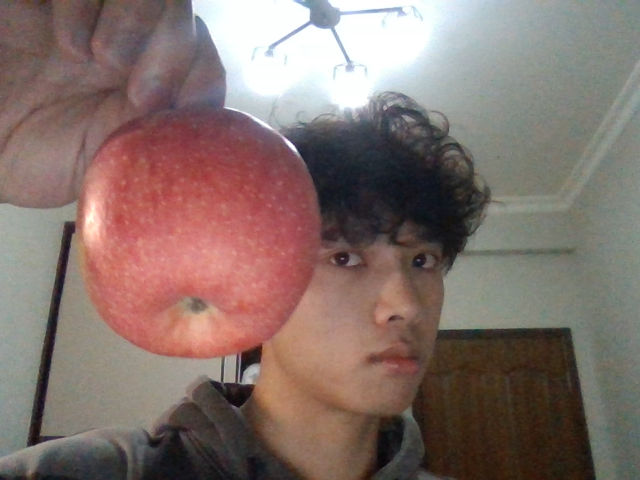

In [28]:
img_pil

In [29]:
input_img = test_transform(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_img) 
pred_softmax = F.softmax(pred_logits, dim=1) 

n = 5
top_n = torch.topk(pred_softmax, n) 
pred_ids = top_n[1].cpu().detach().numpy().squeeze() 
confs = top_n[0].cpu().detach().numpy().squeeze() 

In [30]:
draw = ImageDraw.Draw(img_pil) 

for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
img = np.array(img_pil) 

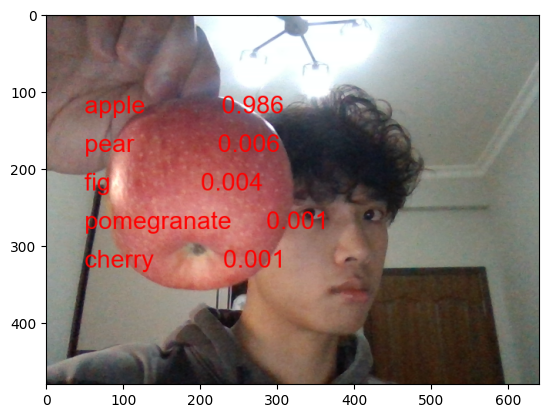

In [31]:
plt.imshow(img)
plt.show()

In [32]:
def process_frame(img):
    
    start_time = time.time()
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_pil = Image.fromarray(img_rgb) 
    input_img = test_transform(img_pil).unsqueeze(0).to(device)
    pred_logits = model(input_img) 
    pred_softmax = F.softmax(pred_logits, dim=1) 
    
    top_n = torch.topk(pred_softmax, 5) 
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()
    confs = top_n[0].cpu().detach().numpy().squeeze() 
    
    draw = ImageDraw.Draw(img_pil) 

    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])

        draw.text((50, 100 + 50 * i),  text, font=font, fill=(255, 0, 0, 1))
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    
    end_time = time.time()

    FPS = 1/(end_time - start_time)  

    img = cv2.putText(img, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img

In [ ]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

while cap.isOpened():

    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    frame = process_frame(frame)
    
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: 
        break
    
cap.release()

cv2.destroyAllWindows()